In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sb

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

%matplotlib inline

data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition-Copy1.csv")
data.dropna(inplace=True)
data.head(10)

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   
5   32        No  Travel_Frequently       1005  Research & Development   
6   59        No      Travel_Rarely       1324  Research & Development   
7   30        No      Travel_Rarely       1358  Research & Development   
8   38        No  Travel_Frequently        216  Research & Development   
9   36        No      Travel_Rarely       1299  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   
5                 2          2  Life Sciences              1               8   
6                 3          3        Medical              1              10   
7                24          1  Life Sciences              1              11   
8                23          3  Life Sciences              1              12   
9                27          3        Medical              1              13   

           ...           RelationshipSatisfaction StandardHours  \
0          ...                                  1            80   
1          ...                                  4            80   
2          ...                                  2            80   
3          ...                                  3            80   
4          ...                                  4            80   
5          ...                                  3            80   
6          ...                                  1            80   
7          ...                                  2            80   
8          ...                                  2            80   
9          ...                                  2            80   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0                 0                  8                      0               1   
1                 1                 10                      3               3   
2                 0                  7                      3               3   
3                 0                  8                      3               3   
4                 1                  6                      3               3   
5                 0                  8                      2               2   
6                 3                 12                      3               2   
7                 1                  1                      2               3   
8                 0                 10                      2               3   
9                 2                 17                      3               2   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0               6                  4                        0   
1              10                  7                        1   
2               0                  0                        0   
3               8                  7                        3   
4               2                  2                        2   
5               7                  7                        3   
6               1                  0                        0   
7               1                  0                        0   
8               9                  7                        1   
9               7          

After uploading my data into 'data', I am in the process of compiling down my data by extracting and manipulating code into a workable dataset. To do this I first need to determine all the different types of values and convert them into integers so that I can input it into sklearn cross validation as well as for the heatmap.

In [2]:
#Here I created new features that convert string based classifiers into integers to denote their values so that cross validation and hold outs can work using those values
data['IntBusinessTravel'] = data['BusinessTravel'].apply(lambda x:0 if x == "Non-Travel" else (1 if x == "Travel_Rarely" else 2))
data['IntDepartment'] = data['Department'].apply(lambda x:0 if x == "Research & Development" else (1 if x == "Sales" else 2))
data['IntEducationField'] = data['EducationField'].apply(lambda x:0 if x == "Life Sciences" else (1 if x == "Medical" else (2 if x == "Marketing" else (3 if x == 'Technical Degree' else (4 if x == 'Other' else 5)))))
data['IntGender'] = data['Gender'].apply(lambda x:0 if x == "Female" else 1)
data['IntAttrition'] = data['Attrition'].apply(lambda x:0 if x == "No" else 1)

In [3]:
#Here I create a seperate table that only has attrition as 0 for no and 1 for yes for use in cross validation and holdout
target = data['Attrition'].copy()
target = target.apply(lambda x:0 if x == "No" else 1)

#Here I created another table with just the features I want to test out for the incoming question
feature_cols = ['Age','DistanceFromHome','Education','RelationshipSatisfaction','WorkLifeBalance']
newdata = data[feature_cols].copy()

Question: Can we predict the Attrition rate based on factors that are uncontrollable by the company? (Such as education, gender, distance from work etc.)

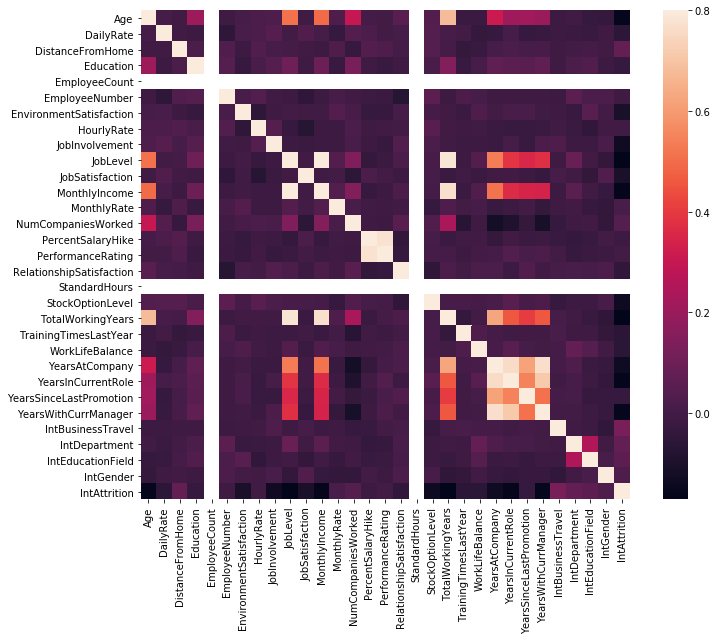

In [4]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8,square=True)
plt.show()

By creating a heat map we can use it to tell us how closely some values are correlated to each other. For Attrition it seems that it has some correlation towards certain values, most notably Business Travel and Distance From Home. There does not seem to be much co-relation with Age or Education however.

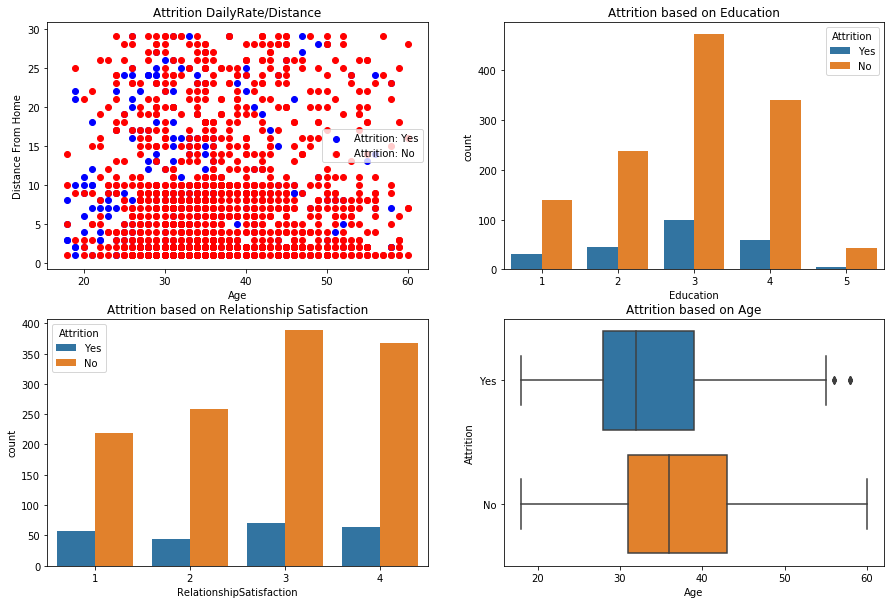

In [5]:
# Look at our data.
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.scatter(
    data[data['IntAttrition'] == 1].Age,
    data[data['IntAttrition'] == 1].DistanceFromHome,
    color='blue'
)
plt.scatter(
    data[data['IntAttrition'] == 0].Age,
    data[data['IntAttrition'] == 0].DistanceFromHome,
    color='red'
)
plt.legend(['Attrition: Yes', 'Attrition: No'])
plt.title('Attrition DailyRate/Distance')
plt.xlabel('Age')
plt.ylabel('Distance From Home')

plt.subplot(2, 2, 2)
sb.countplot(data=data, x="Education", hue="Attrition")
plt.title('Attrition based on Education')

plt.subplot(2, 2, 3)
sb.countplot(data=data, x="RelationshipSatisfaction", hue="Attrition")
plt.title('Attrition based on Relationship Satisfaction')

plt.subplot(2, 2, 4)
sb.boxplot(x=data.Age, y=data.Attrition)
plt.title('Attrition based on Age')
plt.show()

Looking at the data these graphs aren't too helpful in determining how they affect attrition, but it does give us some indicators as to which stages of each attribute has the most attrition (for example a BA degree in Education has a much higher rate of attrition then the others).

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(newdata)
print(pca.explained_variance_ratio_) #Shows how much variance the first and second dimensional space has
print(pca.explained_variance_ratio_.cumsum())  #Shows that at n_components=2 I retain .98% of the variance

[0.54976361 0.43268084]
[0.54976361 0.98244445]


In [7]:
#Use Select K Best after using PCA to determine the number of dimensions to achieve the 2 features that have the greatest variance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=2)
selector.fit(newdata, target)

X_new = selector.transform(newdata)
print(X_new.shape)

newdata.columns[selector.get_support(indices=True)]

newdata.columns[selector.get_support(indices=True)].tolist()

(1470, 2)


['Age', 'DistanceFromHome']

In [8]:
#sets newdata to only contain the two features that will give us the most variance
newdata = newdata[['Age', 'DistanceFromHome']].copy()

In [9]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

from sklearn.model_selection import cross_val_score
cross_val_score(bnb, newdata, target, cv=10)

array([0.83783784, 0.83783784, 0.83783784, 0.83673469, 0.83673469,
       0.83673469, 0.83673469, 0.84246575, 0.84246575, 0.84246575])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(newdata, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(newdata, target).score(newdata, target)))

With 20% Holdout: 0.826530612244898
Testing on Sample: 0.8387755102040816


Here I first used a BNB model to try to test against the model for cross validation. With this I was able to achieve a rough .84 accuracy across all my models which is both pretty accurate and clustered, which is good. Now to test it as a decision tree. With the holdout scoring fairly similarly to the rest of the sample, even thou the model is heavily skewed towards "no" attrition, shows our model is effective. 

--- 0.0 seconds ---


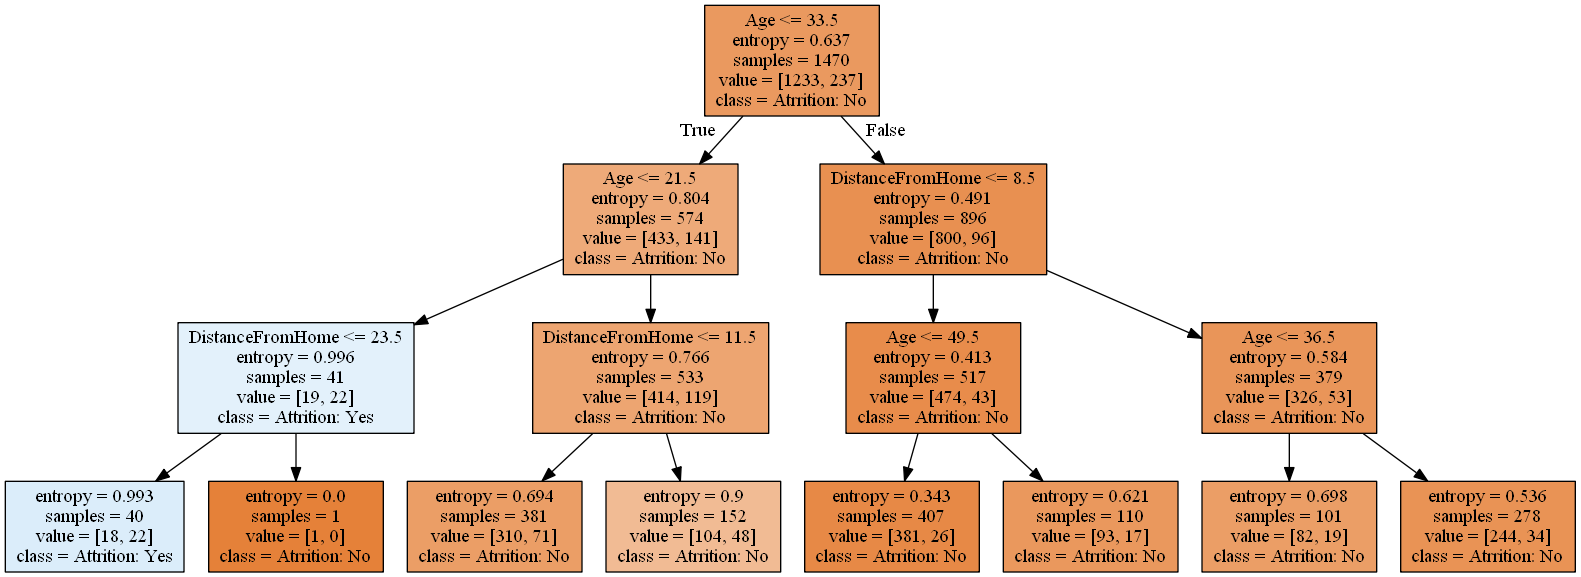

In [12]:
import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features = 2,
    max_depth = 3
)
decision_tree.fit(newdata,target)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=newdata.columns,
    class_names=['Atrrition: No', 'Attrition: Yes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [13]:
cross_val_score(decision_tree, newdata, target, cv=10)

array([0.81081081, 0.83108108, 0.83108108, 0.82993197, 0.85034014,
       0.82993197, 0.82993197, 0.83561644, 0.83561644, 0.83561644])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(newdata, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(newdata, target).score(newdata, target)))

With 20% Holdout: 0.826530612244898
Testing on Sample: 0.8414965986394558


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

 Using the decision tree I created, it wasn't as percise as the BNB model but still relatively accurate, with fluctuations ranging from .82 to .85! I could probably make this more accurate my increasing the number of features and the depths of the tree to allow for more testing, but I thought a depth of 4 and features at 3 was enough and anymore would make it too much slower for the amount of accuracy it'll attain. Now to test if the random tree is better.

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 2,
    max_depth = 3
    )
cross_val_score(rfc, newdata, target, cv=10)

array([0.83108108, 0.85135135, 0.84459459, 0.83673469, 0.82993197,
       0.82993197, 0.82993197, 0.84246575, 0.82876712, 0.83561644])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(newdata, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfc.fit(newdata, target).score(newdata, target)))

With 20% Holdout: 0.8367346938775511
Testing on Sample: 0.8428571428571429


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

With the random tree I was able to attain ranges that are more precise then the decision tree I created. Time wise, if I include the visual graphs for the decision tree, then the overall process is .25 for it to be compiled, while the random tree takes about .17. 